In [1]:
import os
from utils import *
import optuna
from Data_manager.Dataset import *

In [2]:
data, usermap, itemmap, users = load_data2()
data_train, data_val = split_data2(data, 0.2)

In [3]:
from Recommenders.Recommender_import_list import *

candidate_generator_recommender = ItemKNNCFRecommender(data_train)
candidate_generator_recommender.fit()

c:\Users\Francesco1\miniconda3\envs\RecSysFramework\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Tensorflow is not available
ItemKNNCFRecommender: URM Detected 218 ( 1.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 139 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 8522.94 column/sec. Elapsed time 2.61 sec


In [4]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = data_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [5]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12633,NaN
12634,NaN
12635,NaN


In [6]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 12638/12638 [00:07<00:00, 1643.77it/s]


In [7]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,674
0,587
0,1118
0,4
0,1449
...,...
12637,1266
12637,5481
12637,982


In [8]:
URM_validation_coo = sps.coo_matrix(data_val)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,4
1,0,6
2,0,7
3,0,14
4,0,15
...,...,...
95741,12637,7533
95742,12637,8356
95743,12637,13074
95744,12637,13248


In [9]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,674,left_only
1,0,587,left_only
2,0,1118,left_only
3,0,4,both
4,0,1449,left_only
...,...,...,...
379135,12637,1266,left_only
379136,12637,5481,left_only
379137,12637,982,left_only
379138,12637,284,left_only


In [10]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,674,False
1,0,587,False
2,0,1118,False
3,0,4,True
4,0,1449,False
...,...,...,...
379135,12637,1266,False
379136,12637,5481,False
379137,12637,982,False
379138,12637,284,False


In [11]:
topPop = TopPop(data_train)
topPop.fit()

p3alpha = P3alphaRecommender(data_train)
p3alpha.fit()

slimbpr = SLIM_BPR_Cython(data_train)
slimbpr.fit()


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM_BPR": slimbpr,
}

TopPopRecommender: URM Detected 218 ( 1.7%) users with no interactions.
TopPopRecommender: URM Detected 139 ( 0.6%) items with no interactions.
P3alphaRecommender: URM Detected 218 ( 1.7%) users with no interactions.
P3alphaRecommender: URM Detected 139 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 3148.57 column/sec. Elapsed time 7.06 sec
SLIM_BPR_Recommender: URM Detected 218 ( 1.7%) users with no interactions.
SLIM_BPR_Recommender: URM Detected 139 ( 0.6%) items with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 12638 (100.0%) in 0.12 sec. BPR loss is 2.54E-07. Sample per second: 108832
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.04 sec
Processed 12638 (100.0%) in 0.15 sec. BPR loss is 8.65E-07. Sample per second: 83665
SLIM_BPR_Reco

In [12]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/12638 [00:00<?, ?it/s]

100%|██████████| 12638/12638 [00:19<00:00, 643.25it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR
0,0,674,False,338.0,0.000000,0.015766
1,0,587,False,579.0,0.000000,0.017152
2,0,1118,False,107.0,0.013226,0.007022
3,0,4,True,211.0,0.009106,0.009383
4,0,1449,False,102.0,0.000000,0.005022
...,...,...,...,...,...,...
379135,12637,1266,False,758.0,0.000000,0.017976
379136,12637,5481,False,68.0,0.009487,0.009741
379137,12637,982,False,397.0,0.000000,0.012169
379138,12637,284,False,1134.0,0.000000,0.022574


In [13]:
item_popularity = np.ediff1d(sps.csc_matrix(data_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity
0,0,674,False,338.0,0.000000,0.015766,338
1,0,587,False,579.0,0.000000,0.017152,579
2,0,1118,False,107.0,0.013226,0.007022,107
3,0,4,True,211.0,0.009106,0.009383,211
4,0,1449,False,102.0,0.000000,0.005022,102
...,...,...,...,...,...,...,...
379135,12637,1266,False,758.0,0.000000,0.017976,758
379136,12637,5481,False,68.0,0.009487,0.009741,68
379137,12637,982,False,397.0,0.000000,0.012169,397
379138,12637,284,False,1134.0,0.000000,0.022574,1134


In [14]:
user_popularity = np.ediff1d(sps.csr_matrix(data_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,674,False,338.0,0.000000,0.015766,338,31
1,0,587,False,579.0,0.000000,0.017152,579,31
2,0,1118,False,107.0,0.013226,0.007022,107,31
3,0,4,True,211.0,0.009106,0.009383,211,31
4,0,1449,False,102.0,0.000000,0.005022,102,31
...,...,...,...,...,...,...,...,...
379135,12637,1266,False,758.0,0.000000,0.017976,758,61
379136,12637,5481,False,68.0,0.009487,0.009741,68,61
379137,12637,982,False,397.0,0.000000,0.012169,397,61
379138,12637,284,False,1134.0,0.000000,0.022574,1134,61


In [15]:
training_dataframe = training_dataframe.drop("ItemID", axis=1)
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,ItemID,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,0,False,338.0,0.000000,0.015766,338,31
1,1,0,False,579.0,0.000000,0.017152,579,31
2,2,0,False,107.0,0.013226,0.007022,107,31
3,3,0,True,211.0,0.009106,0.009383,211,31
4,4,0,False,102.0,0.000000,0.005022,102,31
...,...,...,...,...,...,...,...,...
379135,379135,12637,False,758.0,0.000000,0.017976,758,61
379136,379136,12637,False,68.0,0.009487,0.009741,68,61
379137,379137,12637,False,397.0,0.000000,0.012169,397,61
379138,379138,12637,False,1134.0,0.000000,0.022574,1134,61


In [16]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [17]:
from xgboost import XGBRanker

In [18]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [19]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [20]:

# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([ 0.39211693,  0.4149501 ,  0.47923598,  0.44486907,  0.4524326 ,
        0.400371  ,  0.04379077,  0.64223164,  0.44588488,  0.2545626 ,
        0.13676159,  0.36303923, -0.03110826, -0.2113302 ,  0.38280413,
        0.14607438, -0.42681107,  0.18830065, -0.3668415 , -0.17168863,
        0.14607438, -0.36606434,  0.07609664,  0.04379077,  0.1993543 ,
       -0.06397945, -0.29511127, -0.16659695,  0.2863002 , -0.45530424],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

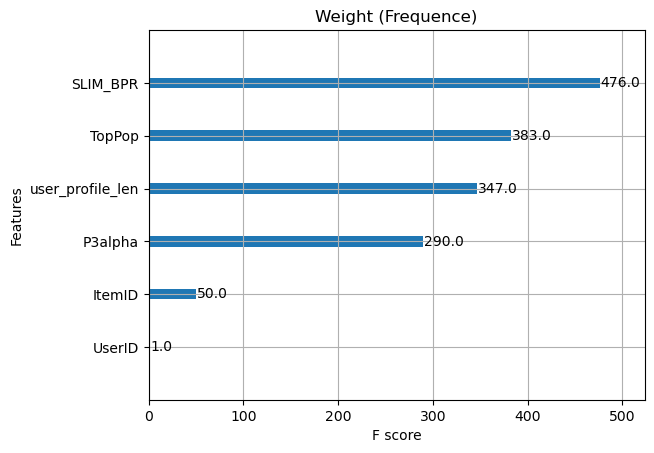

In [21]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [22]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [23]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [24]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.02216959,  0.04303502,  0.16939473,  0.05802363,  0.04303502,
        0.04303502, -0.06045109,  0.07050884,  0.04665288, -0.08283879,
       -0.02216959, -0.08283879, -0.17853755, -0.17853755, -0.02216959,
       -0.02216959, -0.2663074 , -0.02216959, -0.20993966, -0.20993966,
       -0.02216959, -0.20993966, -0.13752964, -0.06045109, -0.11931028,
       -0.06045109, -0.20993966, -0.16295484, -0.10547483, -0.20993966],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

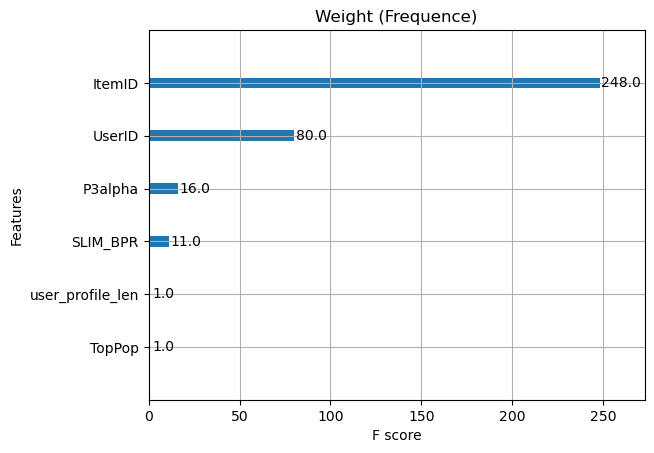

In [25]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [26]:
submission2(XGB_model, users, usermap, itemmap, data_train)

TopPopRecommender: URM Detected 218 ( 1.7%) users with no interactions.
TopPopRecommender: URM Detected 139 ( 0.6%) items with no interactions.


TypeError: score() got an unexpected keyword argument 'cutoff'